<a href="https://colab.research.google.com/github/eriksali/Text-Analytics_LDA/blob/master/lda_silhoette_cluster_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import matplotlib
import time
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)


Saving utils.py to utils (5).py


5237

In [99]:


from utils import load_data
from utils import preprocess_pipeline

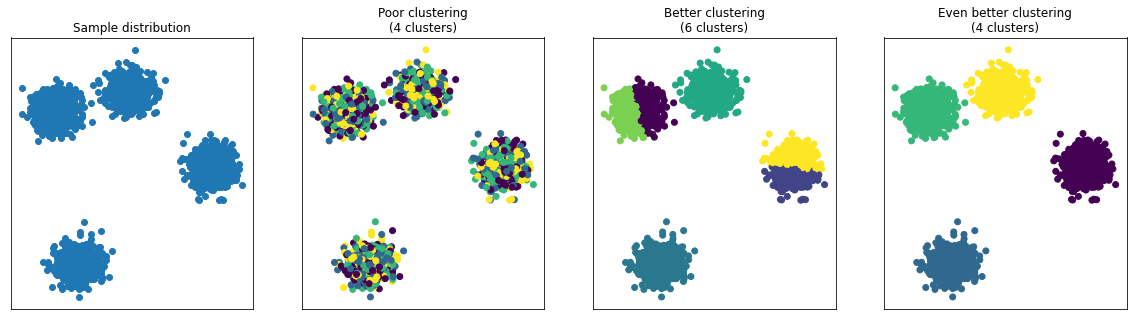

In [9]:
n_samples = 2000
random_state = 42
X, y = make_blobs(n_samples=n_samples, centers= 4, random_state=random_state)

plt.figure(figsize=(20, 5))

plt.subplot(141)
plt.title("Sample distribution")
ax = plt.scatter(X[:, 0], X[:, 1])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

plt.subplot(142)
plt.title("Poor clustering\n(4 clusters)")
ax = plt.scatter(X[:, 0], X[:, 1], c=np.random.randint(size=(n_samples,), low=0, high=4))
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

plt.subplot(143)
plt.title("Better clustering\n(6 clusters)")
y_pred = KMeans(n_clusters=6, random_state=random_state).fit_predict(X)
ax = plt.scatter(X[:, 0], X[:, 1], c=y_pred)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

plt.subplot(144)
plt.title("Even better clustering\n(4 clusters)")
y_pred = KMeans(n_clusters=4, random_state=random_state).fit_predict(X)
ax = plt.scatter(X[:, 0], X[:, 1], c=y_pred)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

#plt.savefig("part-2-images/clustering-101.jpg", dpi=100)
plt.show()

In [82]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [64]:
import os
import pandas as pd

dirpath = '/content/drive/MyDrive/Names/'
output = '/content/drive/MyDrive/name.csv'
csvout_lst = []
files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]

for filename in sorted(files):
    data = pd.read_csv(filename, index_col=0, header=None)
    csvout_lst.append(data)
#csvout_lst.index
#print(csvout_lst)
#print (np.arange(len(csvout_lst.index)))
pd.concat(csvout_lst).to_csv(output, index=True)

In [113]:
from pandas import read_csv
df = read_csv('/content/drive/MyDrive/name.csv')
corpus = df.values
print(corpus)

[['diagon add scalar torch randn plu diag diagon add scalar diag torch eye len torch allclos plu diag diag']
 ['creat token first first tri creat dataset default creator dataset get notifi tri explicitli set notifi true tri explicitli set notifi fals token version activ applic json email address baz gmail com data creat dataset version applic json notifi dataset version applic json notifi dataset version applic json creat dataset notifi respons client post revers kwarg json dump content type token respons json respons client post revers kwarg json dump content type dataset respons json equal respons statu code dataset object get respons json true notifi respons client put revers kwarg dataset json dump content type equal respons statu code equal respons json dataset refresh true notifi respons client put revers kwarg dataset json dump content type equal respons statu code equal respons json dataset refresh fals notifi']
 ['dont restart download job still run job job statu retri downloa

In [114]:
corpus.shape

(1998, 1)

In [115]:
documents = corpus.tolist()

In [116]:
print(documents[5])

['clip window graph surfac coord constant window constant output clip window surfac coord window output output execut graph expect surfac coord array close output expect surfac coord']


In [117]:
start = time.time()
preprocessed_documents = [" ".join(s) for s in documents]
print(f"Preprocessing time: {time.time()-start:.1f}s.")

Preprocessing time: 0.0s.


In [118]:
import nltk
nltk.download('stopwords')
tf_vectorizer = CountVectorizer(max_df=0.80, min_df=10, stop_words=stopwords.words('english')+['like', 'said', 'could', 'would', 'one', 'know', 'us'], max_features=1000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
tf = tf_vectorizer.fit_transform(preprocessed_documents).toarray()


In [124]:
features = tf_vectorizer.get_feature_names_out()

In [125]:
tf.shape

(1998, 785)

In [126]:
len(features)

785

In [127]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [164]:
from utils import print_topics, get_topics_top_words
n_topics = 6
model = LDA(n_components=n_topics, random_state=0)
doc_topic = model.fit_transform(tf)

In [165]:
from sklearn.cluster import KMeans

C = 6
random_state = 42
clusterer = KMeans(n_clusters=C, random_state=random_state)
cluster_labels = clusterer.fit_predict(doc_topic)

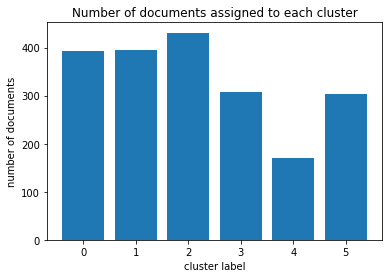

In [166]:
x, y = np.unique(cluster_labels, return_counts=True)
plt.bar(x, y)
plt.xticks(range(C), range(C))
plt.title("Number of documents assigned to each cluster")
plt.xlabel("cluster label")
plt.ylabel("number of documents")
plt.show()

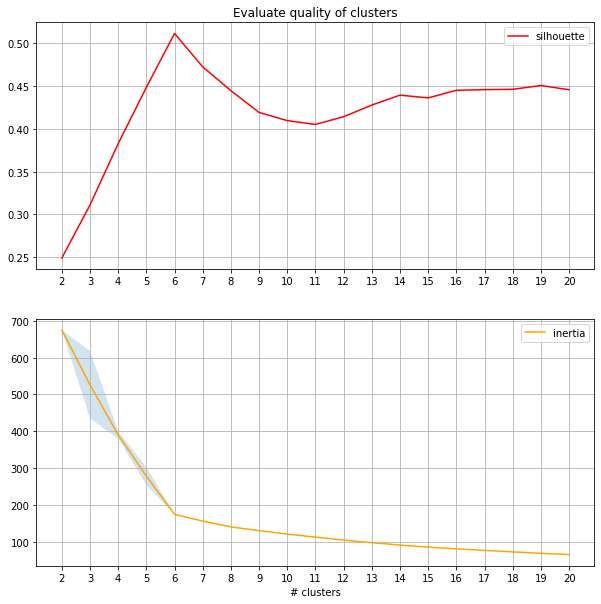

In [167]:
from sklearn import metrics

def plot_cluster_metrics(data, min_clusters=2, max_clusters=20, iters=10):
    n_clusters = []

    wgss_mean = [] # within group sum of squares, or inertia
    wgss_var = [] # variance of results because it's stochastic

    silhouette_mean = []
    silhouette_var = []
    
    for n in range(min_clusters, max_clusters+1):
        n_clusters.append(n)

        wgss_iters = []
        silhouette_iters = []

        for i in range(iters):
            clusterer = KMeans(n_clusters=n).fit(data)
            wgss_iters.append(clusterer.inertia_)
            silhouette_iters.append(metrics.silhouette_score(data,
                                                             clusterer.labels_,
                                                             metric='euclidean'))

        wgss_mean.append(np.array(wgss_iters).mean())
        wgss_var.append(np.array(wgss_iters).var())

        silhouette_mean.append(np.array(silhouette_iters).mean())
        silhouette_var.append(np.array(silhouette_iters).var())

    wgss_mean = np.array(wgss_mean)
    wgss_var = np.array(wgss_var)

    silhouette_mean = np.array(silhouette_mean)
    silhouette_var = np.array(silhouette_var)
    
    # plot every metric
    plt.figure(figsize=(10, 10))
    
    plt.subplot(211)
    plt.xticks(n_clusters)
    plt.plot(n_clusters, silhouette_mean, alpha=1, color='red', label='silhouette')
    plt.fill_between(n_clusters,
                     silhouette_mean-silhouette_var,
                     silhouette_mean+silhouette_var,
                     alpha=0.2)
    plt.title("Evaluate quality of clusters")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(212)
    plt.xticks(n_clusters)
    plt.plot(n_clusters, wgss_mean, alpha=1, label='inertia', color='orange')
    plt.fill_between(n_clusters, wgss_mean-wgss_var, wgss_mean+wgss_var, alpha=0.2)
    plt.xlabel("# clusters")
    plt.legend()
    plt.grid(True)
    
    #plt.savefig("part-2-images/clustering-metrics.jpg", dpi=100)
    plt.show()
    return
plot_cluster_metrics(doc_topic)

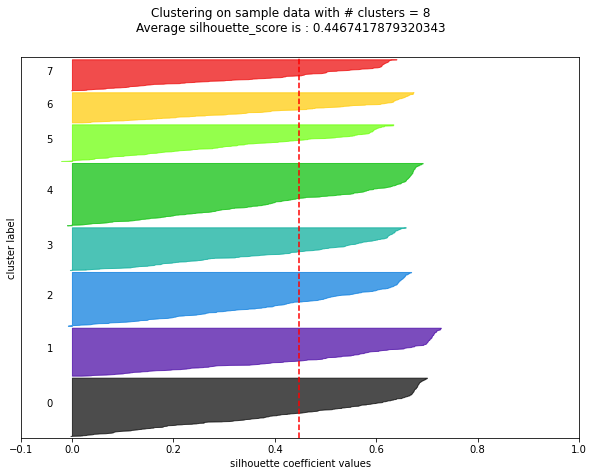

In [163]:
# adapted from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_
# silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

def plot_cluster_silhouette(data, n_clusters, cluster_labels):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(data, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0,
                          ith_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("silhouette coefficient values")
    ax1.set_ylabel("cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Clustering on sample data with # clusters = "
                  + str(n_clusters) + "\nAverage silhouette_score is : "
                  + str(silhouette_avg)))
    
    #plt.savefig("part-2-images/clustering-silhouette.jpg", dpi=100)
    plt.show()
C = n_topics
clusterer = KMeans(n_clusters=C, random_state=random_state)
cluster_labels = clusterer.fit_predict(doc_topic)

plot_cluster_silhouette(doc_topic, C, cluster_labels)